In [1]:
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF

from random import sample

from functions import cosine_perm, simulate_mixedLittle
from AAUtoSig_init import train_AAUtoSig
from optuna_opt import optuna_tune
from torch import optim

## Split data
Firstly we write a method to split the mutational profile matrix into a training and validation set.

In [2]:
def split_data(data, frac_1, frac_2):
  x_tuning = data.sample(frac = frac_1)
  data_new = data.drop(x_tuning.index)
  x_train = data_new.sample(frac=frac_2)
  x_val = data.drop(x_train.index)
  return x_tuning, x_train, x_val

# NMF performance

In [3]:
def out_errorNMF(train_df, validation_df, nsigs ,true_sigs):
  model = NMF(n_components=nsigs, init='random', max_iter = 500)
  exposures = model.fit_transform(train_df)
  signatures = model.components_
  
  cos_NMF = cosine_perm(true_sigs.to_numpy().transpose(), signatures)[0]
  cos_mean = np.mean(cos_NMF.diagonal())


  ref_exposures = model.transform(X = validation_df)
  rec = np.dot(ref_exposures, signatures)
  MSE = np.mean(((validation_df - rec)**2).to_numpy())

  return([cos_mean, MSE])

# AAUtoSig performance

In [4]:
class AAUtoSig(torch.nn.Module):
    def __init__(self, dim1):
        super().__init__()

        
        # Building an linear encoder
        # 96 => dim1 => dim2
        self.enc1 = torch.nn.Linear(96, 200, bias = False)
        self.enc2 = torch.nn.Linear(200, 150, bias = False)
        self.enc3 = torch.nn.Linear(150, 100, bias = False)
        self.enc4 = torch.nn.Linear(100, 50, bias = False)
        self.enc5  = torch.nn.Linear(50, dim1, bias = False)


          
        # Building an linear decoder 
        # dim2 => dim1 => 96
        self.dec2 = torch.nn.Linear(dim1, 96, bias = False)
            

    def forward(self, x):
        x = F.softplus(self.enc1(x))
        x = F.softplus(self.enc2(x))
        x = F.softplus(self.enc3(x))
        x = F.softplus(self.enc4(x))
        x = F.softplus(self.enc5(x))
        x = F.softplus(self.dec2(x))
        return x
        


In [5]:
def out_errorAE(tuning_df, train_df, validation_df, nsigs, true_sigs):
  params = optuna_tune(tuning_df, nsigs)
  lr = params['lr']
  batch_size = params['batch_size']
  optimizer_name = params['optimizer']
  model = AAUtoSig(dim1 = nsigs)

  # Validation using MSE Loss function
  loss_function = torch.nn.MSELoss(reduction='mean')

  optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

                              
  train_AAUtoSig(epochs = 500, 
                model = model, 
                x_train = train_df, 
                loss_function = loss_function, 
                optimizer = optimizer,
                batch_size = int(batch_size)
)

  W = model.dec2.weight.data    
  W_array = W.numpy()

  cos_AE = cosine_perm(true_sigs.to_numpy().transpose(),W_array.transpose())[0]
  cos_mean = np.mean(cos_AE.diagonal())

  x_validation_tensor = torch.tensor(validation_df.values, 
                                      dtype = torch.float32)
  rec = model(x_validation_tensor)
  MSE = (float(loss_function(rec,x_validation_tensor).detach().numpy()))

  return([cos_mean, MSE])

## Performance analysis

In [6]:
def performance_analysis(npatients, nsigs):
  mut_matrix, signatures = simulate_mixedLittle(nsigs, npatients)
  tuning_data, train_data, validation_data = split_data(mut_matrix.transpose(), 0.3, 0.8)
  return(out_errorNMF(pd.concat([tuning_data, train_data]), validation_data, nsigs, signatures) + out_errorAE(tuning_data, train_data, validation_data, nsigs, signatures))
asd = np.zeros((50,4))
for i in range(50):
  asd[i,:] = performance_analysis(5000, 5)
  print(i)
result = pd.DataFrame(asd)
result.columns = ["cosineNMF", "outNMF", "cosineAE", "outAE"]


0


C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


1
2
3
4


[W 2022-04-26 12:05:07,292] Trial 4 failed, because the objective function returned nan.


5
6
7


C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


8
9


[W 2022-04-26 13:11:39,988] Trial 4 failed, because the objective function returned nan.


10
11
12


C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


13
14


C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


15
16
17
18
19
20
21
22
23
24
25
26
27


C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


28


C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


29


C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


30
31
32
33
34


C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


35


C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


36
37
38
39


C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


40
41


C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


42
43


C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


44
45
46
47
48
49


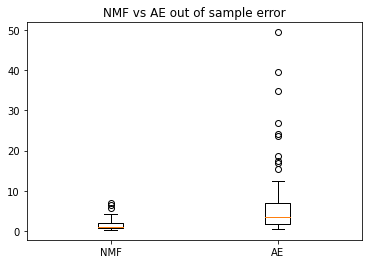

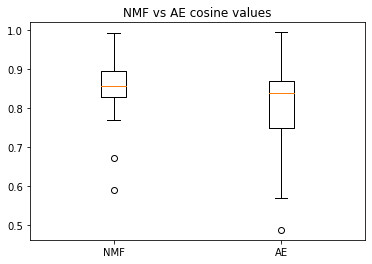

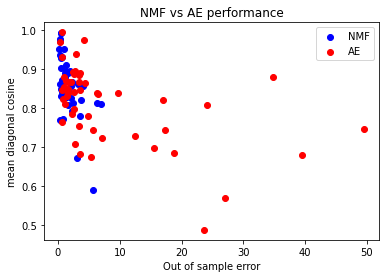

In [7]:
plt.boxplot(result[['outNMF', 'outAE']], labels = ["NMF", "AE"])
plt.title('NMF vs AE out of sample error')
plt.show()

plt.boxplot(result[['cosineNMF', 'cosineAE']] ,labels = ["NMF", "AE"])
plt.title('NMF vs AE cosine values')
plt.show()

plt.scatter(y = result['cosineNMF'], x = result['outNMF'], c = 'blue', label = 'NMF')
plt.scatter(y = result['cosineAE'], x = result['outAE'], c = 'red', label = 'AE')
plt.xlabel('Out of sample error')
plt.ylabel('mean diagonal cosine')
plt.title('NMF vs AE performance')
plt.legend()
plt.show()